In [ ]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [26]:
class IceExtentDataset(Dataset):
    def __init__(self, sequences, targets):

        self.sequences = torch.FloatTensor(sequences).unsqueeze(-1)
        self.targets   = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):

        return self.sequences[idx], self.targets[idx]


In [27]:
class IceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=3, dropout=0.2):
        super(IceLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,      # 1 (ice extent value)
            hidden_size=hidden_size,    # 64 (64 LSTM units)
            num_layers=num_layers,      # 3 (stack 3 LSTM layers)
            batch_first=True,           # Input shape: (batch, seq, features)
            dropout=dropout if num_layers > 1 else 0  # Only dropout if >1 layer
        )

        # Output layer
        self.linear = nn.Linear(hidden_size, 1)  # 64 → 1 (final prediction)
        self.dropout = nn.Dropout(dropout)       # Extra dropout before output

    def forward(self, x):


        lstm_out, _ = self.lstm(x)

        last_output = lstm_out[:, -1, :]

        # Apply dropout and linear layer
        output = self.dropout(last_output)
        prediction = self.linear(output)

        return prediction

In [28]:
class MultiStepLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2,
                 dropout=0.2, horizon=12):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # Now output a vector of length `horizon`
        self.fc = nn.Linear(hidden_size, horizon)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [batch, window, 1]
        out, _   = self.lstm(x)           # out: [batch, window, hidden_size]
        last     = out[:, -1, :]          # take last time step → [batch, hidden_size]
        dropped  = self.dropout(last)
        return self.fc(dropped)           # → [batch, horizon]


In [29]:
def make_multistep_dataset(weekly_data, window=64, horizon=52):
    X, Y = [], []
    for i in range(len(weekly_data) - window - horizon + 1):
        X.append(weekly_data[i : i + window])
        Y.append(weekly_data[i + window : i + window + horizon])
    return np.stack(X), np.stack(Y)

In [30]:
def load_and_preprocess_ice_data(csv_file_path='N_seaice_extent_daily_v3.0.csv'):
    """
    Complete preprocessing pipeline with ZERO data leakage - proper prediction-based splitting
    """
    # Read CSV, skip the header row with units
    df = pd.read_csv(csv_file_path, skiprows=0)
    print(df)
    # Clean column names (remove extra spaces)
    df.columns = df.columns.str.strip()

    # Filter out the header row and invalid data
    df_clean = df[df['Year'].apply(lambda x: str(x).isdigit())].copy()
    df_clean = df_clean[df_clean['Year'].astype('int') >= 1978].copy()

    # Convert to numeric
    df_clean['Year'] = pd.to_numeric(df_clean['Year'])
    df_clean['Month'] = pd.to_numeric(df_clean['Month'])
    df_clean['Day'] = pd.to_numeric(df_clean['Day'])
    df_clean['Extent'] = pd.to_numeric(df_clean['Extent'])

    # Extract daily extents
    daily_extents = df_clean['Extent'].values

    weekly_data = []
    for i in range(0, len(daily_extents) - 6, 7):  # Every 7 days
        week = daily_extents[i:i+7]
        if len(week) == 7:
            valid_values = week[~np.isnan(week) & (week > 0)]
            if len(valid_values) >= 5:
                weekly_avg = np.mean(valid_values)
                weekly_data.append(round(weekly_avg, 3))

    weekly_data = np.array(weekly_data)

    # FINAL FIX: Split based on PREDICTION weeks, not input weeks
    sequence_length = 64
    horizon = 12

    print(f"Total weeks: {len(weekly_data)}")

    # Calculate the range of weeks we can make predictions for
    first_predictable_week = sequence_length  # Week 64 (using weeks 0-63)
    last_predictable_week = len(weekly_data) - 1  # Week N-1
    total_predictable_weeks = last_predictable_week - first_predictable_week + 1

    print(f"Predictable range: weeks {first_predictable_week} to {last_predictable_week}")
    print(f"Total predictable weeks: {total_predictable_weeks}")

    # 80% of predictions for training
    num_train_predictions = int(0.8 * total_predictable_weeks)

    # Training predictions: weeks 64 to (64 + num_train_predictions - 1)
    last_train_prediction_week = first_predictable_week + num_train_predictions - 1
    first_test_prediction_week = last_train_prediction_week + 1

    print(f"Training predictions end at week: {last_train_prediction_week}")
    print(f"Test predictions start at week: {first_test_prediction_week}")

    # For multi-step predictions, we need to be more careful
    # Training sequences will predict weeks up to last_train_prediction_week
    # The last training sequence predicts weeks (last_train_prediction_week - horizon + 1) to last_train_prediction_week
    # This sequence uses inputs from weeks (last_train_prediction_week - horizon + 1 - sequence_length) to (last_train_prediction_week - horizon)

    last_training_input_week = last_train_prediction_week
    train_data = weekly_data[:last_training_input_week + 1]

    # For test data, we need inputs starting from (first_test_prediction_week - sequence_length)
    first_test_input_week = first_test_prediction_week - sequence_length
    test_data = weekly_data[first_test_input_week:]

    print(f"Training data: weeks 0 to {len(train_data) - 1}")
    print(f"Test data: weeks {first_test_input_week} to {len(weekly_data) - 1}")

    # Create sequences
    X_train_raw, y_train_raw = make_multistep_dataset(train_data,
                                                     window=sequence_length,
                                                     horizon=horizon)
    X_test_raw, y_test_raw = make_multistep_dataset(test_data,
                                                   window=sequence_length,
                                                   horizon=horizon)

    print(f"✅ Temporal split completed:")
    print(f"   Training sequences: {len(X_train_raw)}")
    print(f"   Test sequences: {len(X_test_raw)}")

    # Verify no prediction overlap
    if len(X_train_raw) > 0:
        # Last training sequence uses inputs train_data[-sequence_length:]
        # and predicts the next horizon weeks after train_data
        actual_last_train_prediction = len(train_data) - 1 + horizon
        print(f"   Last training prediction week: {actual_last_train_prediction}")

    if len(X_test_raw) > 0:
        # First test sequence uses inputs test_data[:sequence_length]
        # and predicts weeks starting from first_test_input_week + sequence_length
        actual_first_test_prediction = first_test_input_week + sequence_length
        print(f"   First test prediction week: {actual_first_test_prediction}")

        if len(X_train_raw) > 0:
            if actual_last_train_prediction < actual_first_test_prediction:
                gap = actual_first_test_prediction - actual_last_train_prediction - 1
                print(f"   ✅ Perfect separation: {gap} week gap between predictions")
            else:
                overlap = actual_last_train_prediction - actual_first_test_prediction + 1
                print(f"   ❌ Still {overlap} weeks of prediction overlap!")

    # Fit scaler only on training data
    scaler = StandardScaler()

    train_all_vals = np.concatenate([
        X_train_raw.flatten(),
        y_train_raw.flatten()
    ])
    scaler.fit(train_all_vals.reshape(-1, 1))

    # Transform training data
    X_train = scaler.transform(
        X_train_raw.reshape(-1, 1)
    ).reshape(X_train_raw.shape)
    y_train = scaler.transform(
        y_train_raw.flatten().reshape(-1, 1)
    ).reshape(y_train_raw.shape)

    # Transform test data (using scaler fitted on training data only)
    X_test = scaler.transform(
        X_test_raw.reshape(-1, 1)
    ).reshape(X_test_raw.shape)
    y_test = scaler.transform(
        y_test_raw.flatten().reshape(-1, 1)
    ).reshape(y_test_raw.shape)

    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'scaler': scaler,
        'weekly_data': weekly_data,
        'train_prediction_end': last_train_prediction_week,
        'test_prediction_start': first_test_prediction_week
    }

In [31]:
def train_lstm_model(csv_file_path='N_seaice_extent_daily_v3.0.csv'):
    """
    Complete LSTM training pipeline for Arctic sea ice prediction
    """

    print("🧊 Starting Arctic Sea Ice LSTM Training")
    print("=" * 60)

    # Step 1: Load and preprocess data
    print("📊 Step 1: Loading and preprocessing data...")
    data = load_and_preprocess_ice_data(csv_file_path)

    print(f"✅ Data loaded:")
    print(f"   Training examples: {len(data['X_train'])}")
    print(f"   Test examples: {len(data['X_test'])}")
    print(f"   Input shape: (batch_size, 12, 1)")
    print(f"   Output shape: (batch_size, 1)")

    # Step 2: Create datasets and data loaders
    print("\n🔄 Step 2: Creating datasets and data loaders...")

    train_dataset = IceExtentDataset(data['X_train'], data['y_train'])
    test_dataset = IceExtentDataset(data['X_test'], data['y_test'])

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Inside train_lstm_model, right after creating train_loader:
    for Xb, Yb in train_loader:
        print(Xb.shape, Yb.shape)
        break
# Should now print: torch.Size([32, 64, 1]) torch.Size([32, 12])

    print(f"✅ DataLoaders created:")
    print(f"   Batch size: {batch_size}")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Test batches: {len(test_loader)}")

    # Test a batch to make sure everything works
    for batch_X, batch_y in train_loader:
        print(f"   Sample batch shapes: X={batch_X.shape}, y={batch_y.shape}")
        break

    # Step 3: Initialize model and training components
    print("\n🧠 Step 3: Initializing model...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"   Device: {device}")

    model = MultiStepLSTM(
        input_size=1,
        hidden_size=64,
        num_layers=2,
        dropout=0.2,
        horizon=12        # predict 12 weeks ahead
    ).to(device)


    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"   Model parameters: {total_params:,} total, {trainable_params:,} trainable")

    # Training setup
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)

    # Step 4: Training loop
    print("\n🚀 Step 4: Training LSTM...")

    num_epochs = 200
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience_counter = 0
    patience = 15

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping (important for LSTMs!)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        test_loss = 0.0

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                test_loss += loss.item()

        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)

        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        # Learning rate scheduling
        scheduler.step(avg_test_loss)

        # Early stopping and model saving
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), 'best_ice_lstm.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        # Print progress
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            elapsed = time.time() - start_time
            print(f'Epoch {epoch:3d}: Train={avg_train_loss:.6f}, Test={avg_test_loss:.6f}, '
                  f'LR={optimizer.param_groups[0]["lr"]:.6f}, Time={elapsed:.1f}s')

        # Early stopping
        if patience_counter >= patience:
            print(f"⏹️  Early stopping at epoch {epoch}")
            break

    total_time = time.time() - start_time
    print(f"\n✅ Training complete! Total time: {total_time:.1f}s")

    # Step 5: Load best model and evaluate
    print("\n📈 Step 5: Final evaluation...")

    model.load_state_dict(torch.load('best_ice_lstm.pth'))
    model.eval()

    # Collect all predictions and actuals
    train_preds, train_actuals = [], []
    test_preds, test_actuals = [], []

    with torch.no_grad():
        # Training set predictions
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            pred = model(batch_X)
            train_preds.extend(pred.cpu().numpy())
            train_actuals.extend(batch_y.cpu().numpy())

        # Test set predictions
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            pred = model(batch_X)
            test_preds.extend(pred.cpu().numpy())
            test_actuals.extend(batch_y.cpu().numpy())

    # Convert back to original scale
    train_preds = data['scaler'].inverse_transform(np.array(train_preds))
    train_actuals = data['scaler'].inverse_transform(np.array(train_actuals))
    test_preds = data['scaler'].inverse_transform(np.array(test_preds))
    test_actuals = data['scaler'].inverse_transform(np.array(test_actuals))

    # Calculate metrics
    train_mae = mean_absolute_error(train_actuals, train_preds)
    train_rmse = np.sqrt(mean_squared_error(train_actuals, train_preds))
    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))

    print("📊 Final Results:")
    print(f"   Training   - MAE: {train_mae:.3f} million km², RMSE: {train_rmse:.3f} million km²")
    print(f"   Test       - MAE: {test_mae:.3f} million km², RMSE: {test_rmse:.3f} million km²")
    print(f"   Best epoch - Test loss: {best_test_loss:.6f}")

    # Step 6: Visualize results
    print("\n📊 Step 6: Creating visualizations...")

    plt.figure(figsize=(30, 20))

    # Training curves
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
    plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
    plt.title('Training Curves')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    # Predictions vs Actual (Test Set)
    plt.subplot(2, 3, 2)
    plt.scatter(test_actuals, test_preds, alpha=0.6, color='red')
    min_val, max_val = test_actuals.min(), test_actuals.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.xlabel('Actual Ice Extent (million km²)')
    plt.ylabel('Predicted Ice Extent (million km²)')
    plt.title('Predictions vs Actual (Test Set)')
    plt.grid(True, alpha=0.3)

    # Time series comparison (recent test data)
    plt.subplot(2, 3, 3)
    recent_range = slice(-min(100, len(test_actuals)), None)
    plt.plot(test_actuals[recent_range], label='Actual', linewidth=2, color='blue')
    plt.plot(test_preds[recent_range], label='Predicted', linewidth=2, color='red', alpha=0.8)
    plt.title('Recent Predictions (Test Set)')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Ice Extent (million km²)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Residuals (errors)
    plt.subplot(2, 3, 4)
    residuals = test_actuals - test_preds
    plt.hist(residuals.flatten(), bins=30, alpha=0.7, color='purple')
    plt.title('Prediction Errors Distribution')
    plt.xlabel('Error (million km²)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--', alpha=0.8)
    plt.grid(True, alpha=0.3)

    # Error over time
    plt.subplot(2, 3, 5)
    plt.plot(np.abs(residuals.flatten()), color='orange', alpha=0.7)
    plt.title('Absolute Error Over Time')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Absolute Error (million km²)')
    plt.grid(True, alpha=0.3)

    # Model predictions on full dataset
    plt.subplot(2, 3, 6)
    all_actuals = np.concatenate([train_actuals.flatten(), test_actuals.flatten()])
    all_preds = np.concatenate([train_preds.flatten(), test_preds.flatten()])
    split_point = len(train_actuals)

    x_range = range(len(all_actuals))
    plt.plot(x_range, all_actuals, label='Actual', color='blue', linewidth=1)
    plt.plot(x_range, all_preds, label='Predicted', color='red', alpha=0.8, linewidth=1)
    plt.axvline(split_point, color='green', linestyle='--', alpha=0.8, label='Train/Test Split')
    plt.title('Full Time Series: Actual vs Predicted')
    plt.xlabel('Time (weeks)')
    plt.ylabel('Ice Extent (million km²)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return everything for further analysis
    return {
        'model': model,
        'scaler': data['scaler'],
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_preds': train_preds,
        'train_actuals': train_actuals,
        'test_preds': test_preds,
        'test_actuals': test_actuals,
        'metrics': {
            'train_mae': train_mae,
            'train_rmse': train_rmse,
            'test_mae': test_mae,
            'test_rmse': test_rmse
        }
    }

def predict_future_weeks(model, scaler, recent_weeks, weeks_ahead=8, device='cpu'):
    """
    Predict future ice extent using the trained model

    Args:
        model: Trained LSTM model
        scaler: StandardScaler used during training
        recent_weeks: List of 12 most recent weekly ice extents (raw values)
        weeks_ahead: Number of weeks to predict
        device: Device to run predictions on

    Returns:
        List of predicted ice extents (raw values)
    """
    model.eval()
    predictions = []

    # Normalize recent data
    recent_normalized = scaler.transform(np.array(recent_weeks).reshape(-1, 1)).flatten()
    current_sequence = recent_normalized[-12:].tolist()  # Last 12 weeks

    with torch.no_grad():
        for week in range(weeks_ahead):
            # Prepare input: (1, 12, 1)
            x = torch.FloatTensor(current_sequence).unsqueeze(0).unsqueeze(-1).to(device)

            # Make prediction
            pred = model(x)
            pred_value = pred.item()

            # Store prediction
            predictions.append(pred_value)

            # Update sequence (remove oldest, add newest)
            current_sequence = current_sequence[1:] + [pred_value]

    # Convert back to original scale
    predictions_raw = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    return predictions_raw.tolist()


🧊 Starting Arctic Sea Ice LSTM Training
📊 Step 1: Loading and preprocessing data...
       Year   Month   Day       Extent      Missing  \
0      YYYY      MM    DD   10^6 sq km   10^6 sq km   
1      1978      10    26       10.231        0.000   
2      1978      10    28       10.420        0.000   
3      1978      10    30       10.557        0.000   
4      1978      11    01       10.670        0.000   
...     ...     ...   ...          ...          ...   
15417  2025      07    18        7.557        0.004   
15418  2025      07    19        7.431        0.000   
15419  2025      07    20        7.350        0.000   
15420  2025      07    21        7.252        0.000   
15421  2025      07    22        7.139        0.000   

                                             Source Data  
0       Source data product web sites: http://nsidc.o...  
1       ['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...  
2       ['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...  
3       ['/ecs/DP1/

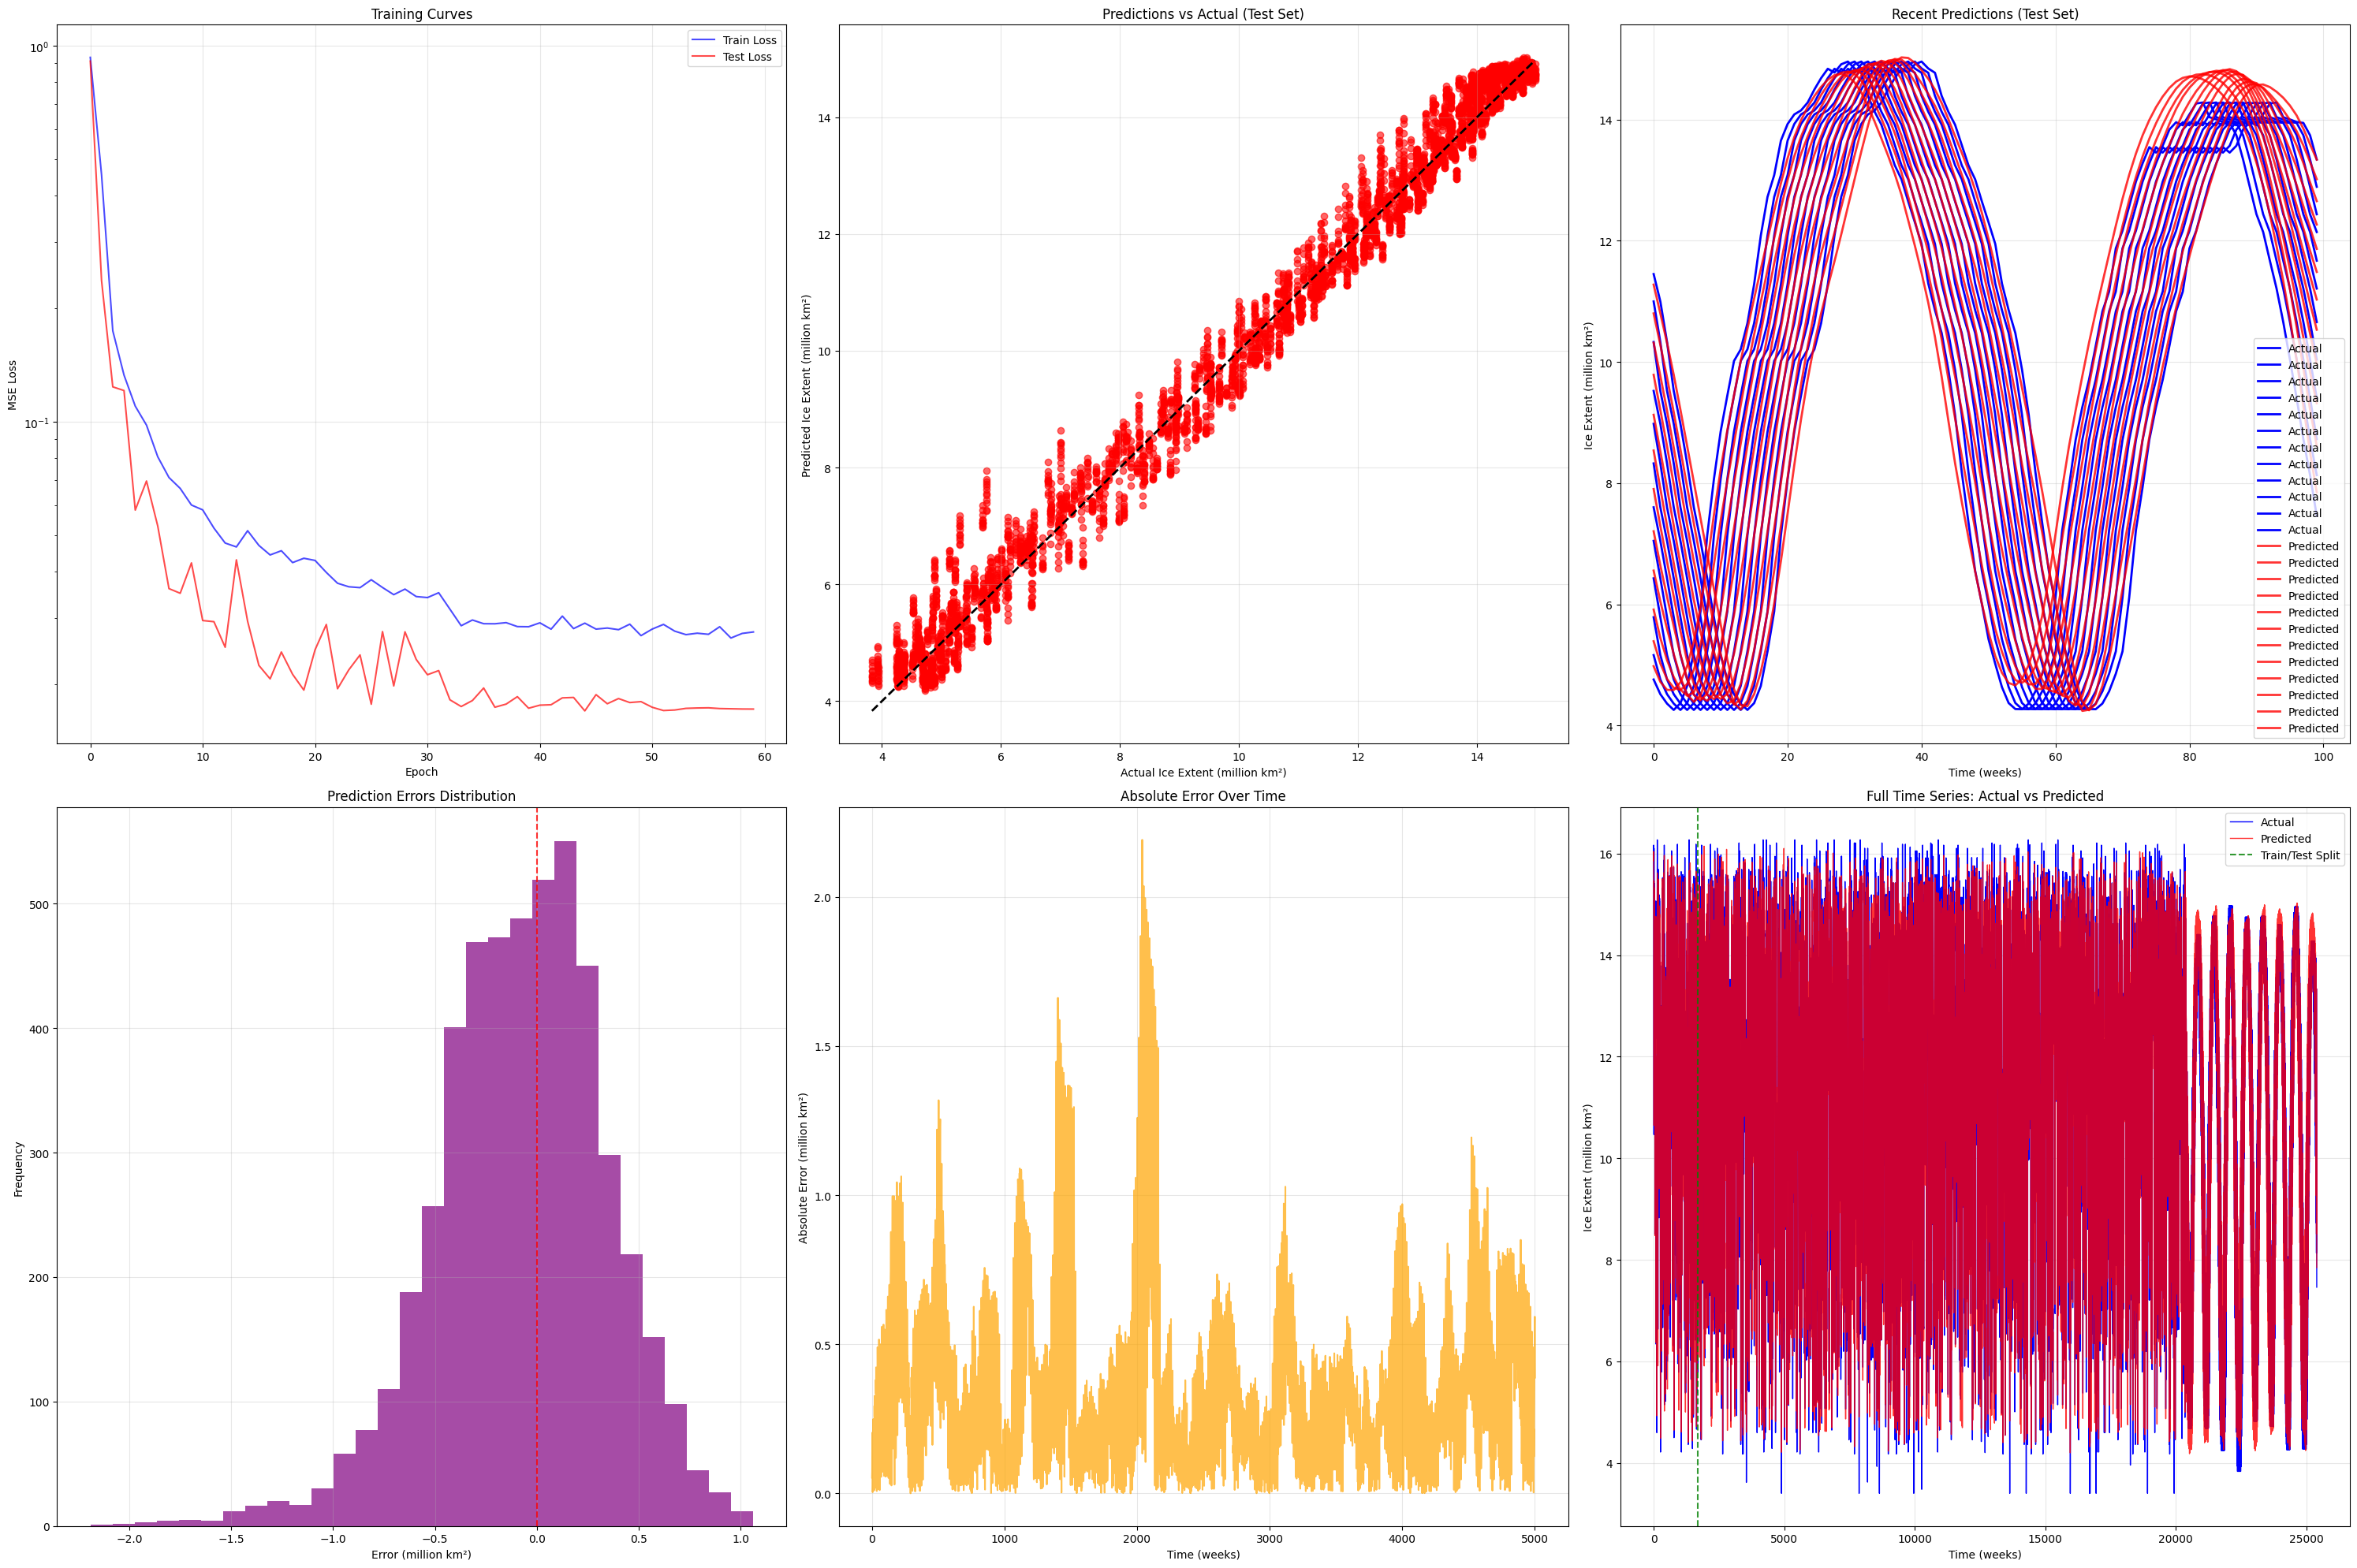

In [32]:
results = train_lstm_model('../data/raw/N_seaice_extent_daily_v3.0.csv')